In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nengo
import time
palette = sns.color_palette("tab10")
sns.set_palette(palette)
sns.set(context='notebook', style='white')

In [2]:
def load_values(load=False, monkeys=['V', 'W'], sessions=range(4), blocks=range(1,25)):
    if load:
        nef_values = pd.read_pickle("data/nef_values.pkl")
    else:
        emp = pd.read_pickle("data/empirical.pkl")
        nef_dfs = []
        rl_dfs = []
        for monkey in monkeys:
            for session in sessions:
                for block in blocks:
                    try:
                        file = f"monkey{monkey}_session{session}_block{block}"
                        nef_dfs.append(pd.read_pickle(f'data/nef/{file}_values.pkl'))
                    except:
                        pass
        nef_values = pd.concat(nef_dfs, ignore_index=True)
        nef_values.to_pickle("data/nef_values.pkl")
    return nef_values

In [3]:
nef_values = load_values(False)

In [4]:
nef_values

,monkey,session,block,trial,block_type,perturb,pre,post,va,vb,vl,vr,w,al,ar,clet,cloc,rew,acc
0,V,0,1,1,what,-0.3,1,-1,-0.006505,-0.001856,-0.002768,0.003404,0.197009,-0.033153,0.105841,B,right,1,1
1,V,0,1,2,what,-0.3,2,-1,0.139605,0.010362,0.024906,0.186482,0.178792,0.007090,0.224681,A,right,1,0
2,V,0,1,3,what,-0.3,3,-1,0.123081,0.157950,0.013098,0.315240,0.154321,0.000927,0.344985,A,right,-1,0
3,V,0,1,4,what,-0.3,4,-1,0.104925,0.027413,-0.007991,0.161868,0.132550,-0.032789,0.215386,A,right,1,0
4,V,0,1,5,what,-0.3,5,-1,0.169885,0.097516,-0.011408,0.289489,0.112677,-0.019534,0.322754,B,right,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197595,W,3,24,76,where,0.3,-1,33,0.061995,-0.110841,-0.019258,0.407851,0.473388,-0.118548,0.127680,A,right,1,0
197596,W,3,24,77,where,0.3,-1,34,0.019891,0.013722,-0.034427,0.530560,0.471182,-0.158737,0.234734,A,right,-1,0
197597,W,3,24,78,where,0.3,-1,35,-0.109697,0.024771,-0.022658,0.364372,0.469453,-0.180828,0.149027,B,right,-1,0
197598,W,3,24,79,where,0.3,-1,36,-0.117368,-0.097062,-0.010223,0.250718,0.469743,-0.165574,0.042709,B,right,-1,0


## Confirm learning

In [6]:
perturb_plots = [-0.3, 0.0, 0.3]
subdata = nef_values.query("perturb in @perturb_plots")

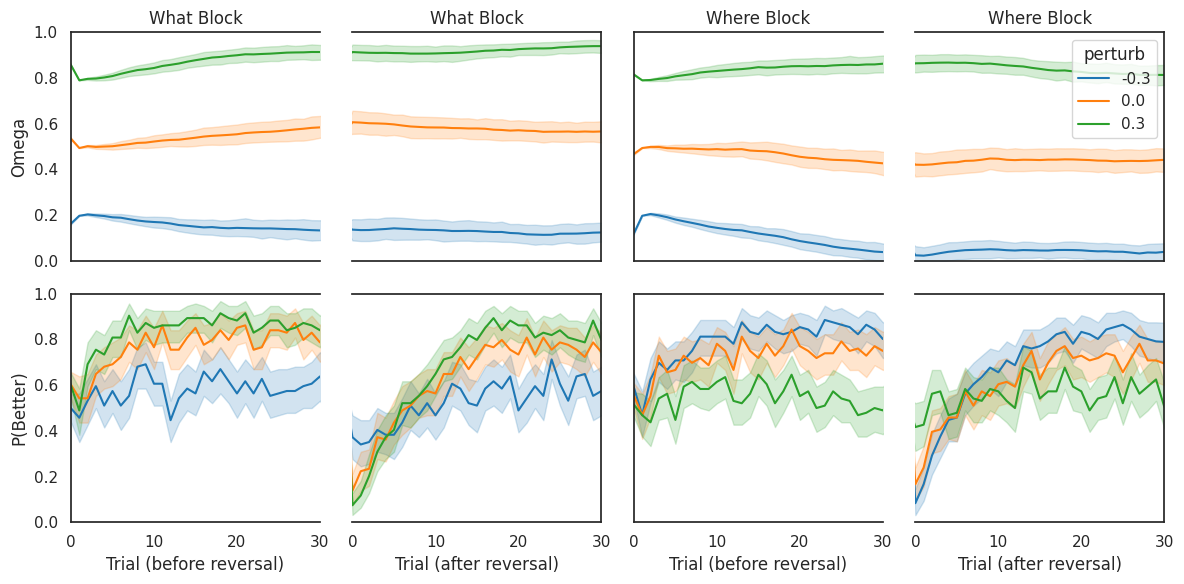

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=4, sharey=True, sharex=True, figsize=(12, 6))
sns.lineplot(subdata.query("block_type=='what'"), x='pre', y='w', hue='perturb', palette=palette[:3], ax=axes[0][0])
sns.lineplot(subdata.query("block_type=='what'"), x='post', y='w', hue='perturb', palette=palette[:3], ax=axes[0][1])
sns.lineplot(subdata.query("block_type=='where'"), x='pre', y='w', hue='perturb', palette=palette[:3], ax=axes[0][2])
sns.lineplot(subdata.query("block_type=='where'"), x='post', y='w', hue='perturb', palette=palette[:3], ax=axes[0][3])
sns.lineplot(subdata.query("block_type=='what'"), x='pre', y='acc', hue='perturb', palette=palette[:3], ax=axes[1][0])
sns.lineplot(subdata.query("block_type=='what'"), x='post', y='acc', hue='perturb', palette=palette[:3], ax=axes[1][1])
sns.lineplot(subdata.query("block_type=='where'"), x='pre', y='acc', hue='perturb', palette=palette[:3], ax=axes[1][2])
sns.lineplot(subdata.query("block_type=='where'"), x='post', y='acc', hue='perturb', palette=palette[:3], ax=axes[1][3])
axes[0][0].set(xlabel='Trial (before reversal)', ylabel='Omega', title='What Block', xlim=(0, 30), ylim=(0,1))
axes[0][1].set(xlabel='Trial (after reversal)', title='What Block')
axes[0][2].set(xlabel='Trial (before reversal)', title='Where Block')
axes[0][3].set(xlabel='Trial (after reversal)', title='Where Block')
axes[0][0].spines['right'].set_visible(False)
axes[0][1].spines['left'].set_visible(False)
axes[0][2].spines['right'].set_visible(False)
axes[0][3].spines['left'].set_visible(False)
axes[0][0].get_legend().remove()
axes[0][1].get_legend().remove()
axes[0][2].get_legend().remove()
axes[1][0].set(ylabel="P(Better)", xlabel='Trial (before reversal)', xlim=(0, 30), ylim=(0,1))
axes[1][1].set(xlabel='Trial (after reversal)')
axes[1][2].set(xlabel='Trial (before reversal)')
axes[1][3].set(xlabel='Trial (after reversal)')
axes[1][0].spines['right'].set_visible(False)
axes[1][1].spines['left'].set_visible(False)
axes[1][2].spines['right'].set_visible(False)
axes[1][3].spines['left'].set_visible(False)
axes[1][0].get_legend().remove()
axes[1][1].get_legend().remove()
axes[1][2].get_legend().remove()
axes[1][3].get_legend().remove()
fig.tight_layout()
fig.savefig("plots/nef_learning_vs_perturbation.pdf")

## Compute Differential Response

In [13]:
def add_DR(data, monkeys=['V', 'W'], sessions=range(4), blocks=range(1,25)):
    dfs = []
    columns = ['monkey', 'session', 'block', 'block_type', 'perturb', 'DR_let', 'DR_loc']
    perturbs = data['perturb'].unique()
    for monkey in monkeys:
        for session in sessions:
            for block in blocks:
                for perturb in perturbs:
                    subdata = data.query("monkey==@monkey & session==@session & block==@block & perturb==@perturb")
                    trials = subdata['trial'].unique()[1:]
                    if len(trials)==0:
                        continue
                    block_type = subdata['block_type'].values[0]
                    n_stay_let_win = 0
                    n_stay_let_lose = 0
                    n_stay_loc_win = 0
                    n_stay_loc_lose = 0
                    for trial in subdata['trial'].unique()[1:]:
                        reward = subdata.query("trial==@trial")['rew'].values[0]
                        past_trial = trial - 1
                        past_let = subdata.query("trial==@past_trial")['clet'].values[0]
                        current_let = subdata.query("trial==@trial")['clet'].values[0]
                        past_loc = subdata.query("trial==@past_trial")['cloc'].values[0]
                        current_loc = subdata.query("trial==@trial")['cloc'].values[0]
                        if current_let==past_let:
                            if reward==1:
                                n_stay_let_win += 1
                            else:
                                n_stay_let_lose += 1
                        if current_loc==past_loc:
                            if reward==1:
                                n_stay_loc_win += 1
                            else:
                                n_stay_loc_lose += 1
                    if n_stay_let_win + n_stay_let_lose > 0:
                        p_stay_let_win = n_stay_let_win / (n_stay_let_win + n_stay_let_lose)
                        p_stay_let_lose = n_stay_let_lose / (n_stay_let_win + n_stay_let_lose)
                        DR_let = p_stay_let_win - p_stay_let_lose
                    else:
                        DR_let = None
                    if n_stay_loc_win + n_stay_loc_lose > 0:
                        p_stay_loc_win = n_stay_loc_win / (n_stay_loc_win + n_stay_loc_lose)
                        p_stay_loc_lose = n_stay_loc_lose / (n_stay_loc_win + n_stay_loc_lose)
                        DR_loc = p_stay_loc_win - p_stay_loc_lose
                    else:
                        DR_loc = None
                    dfs.append(pd.DataFrame([[monkey, session, block, block_type, perturb, DR_let, DR_loc]], columns=columns))
    dr_data = pd.concat(dfs, ignore_index=True)
    return dr_data

In [15]:
def add_zero_centered(data, monkeys=['V', 'W'], sessions=range(4), blocks=range(1,25)):
    perturbs = data['perturb'].unique()
    baseline = (data[data['perturb'] == 0][['monkey', 'session', 'block', 'DR_let', 'DR_loc']]
        .rename(columns={'DR_let': 'DR_let_baseline', 'DR_loc': 'DR_loc_baseline'}))
    data = data.merge(baseline, on=['monkey', 'session', 'block'], how='left')
    data['DR_let_diff'] = data['DR_let'] - data['DR_let_baseline']
    data['DR_loc_diff'] = data['DR_loc'] - data['DR_loc_baseline']
    return data

In [14]:
nef_dr = add_DR(nef_values)

In [16]:
nef_dr0 = add_zero_centered(nef_dr)

In [16]:
nef_dr

,monkey,session,block,block_type,perturb,DR_let,DR_loc
0,V,0,1,what,-0.2,-0.187500,-0.088608
1,V,0,1,what,-0.1,-0.187500,-0.088608
2,V,0,1,what,0.0,-0.187500,-0.116883
3,V,0,1,what,0.1,-0.043478,-0.079365
4,V,0,1,what,0.2,-0.210526,-0.130435
...,...,...,...,...,...,...,...
945,W,3,24,where,-0.2,0.235294,0.139241
946,W,3,24,where,-0.1,0.235294,0.139241
947,W,3,24,where,0.0,0.235294,0.139241
948,W,3,24,where,0.1,0.235294,0.139241


In [17]:
nef_dr0

,monkey,session,block,block_type,perturb,DR_let,DR_loc,DR_let_baseline,DR_loc_baseline,DR_let_diff,DR_loc_diff
0,V,0,1,what,-0.2,-0.187500,-0.088608,-0.187500,-0.116883,0.000000,0.028276
1,V,0,1,what,-0.1,-0.187500,-0.088608,-0.187500,-0.116883,0.000000,0.028276
2,V,0,1,what,0.0,-0.187500,-0.116883,-0.187500,-0.116883,0.000000,0.000000
3,V,0,1,what,0.1,-0.043478,-0.079365,-0.187500,-0.116883,0.144022,0.037518
4,V,0,1,what,0.2,-0.210526,-0.130435,-0.187500,-0.116883,-0.023026,-0.013552
...,...,...,...,...,...,...,...,...,...,...,...
945,W,3,24,where,-0.2,0.235294,0.139241,0.235294,0.139241,0.000000,0.000000
946,W,3,24,where,-0.1,0.235294,0.139241,0.235294,0.139241,0.000000,0.000000
947,W,3,24,where,0.0,0.235294,0.139241,0.235294,0.139241,0.000000,0.000000
948,W,3,24,where,0.1,0.235294,0.139241,0.235294,0.139241,0.000000,0.000000


In [23]:
nef_dr['perturb'].unique()

array([-0.3 , -0.25, -0.2 , -0.15, -0.1 , -0.05,  0.  ,  0.05,  0.1 ,
        0.15,  0.2 ,  0.25,  0.3 ])

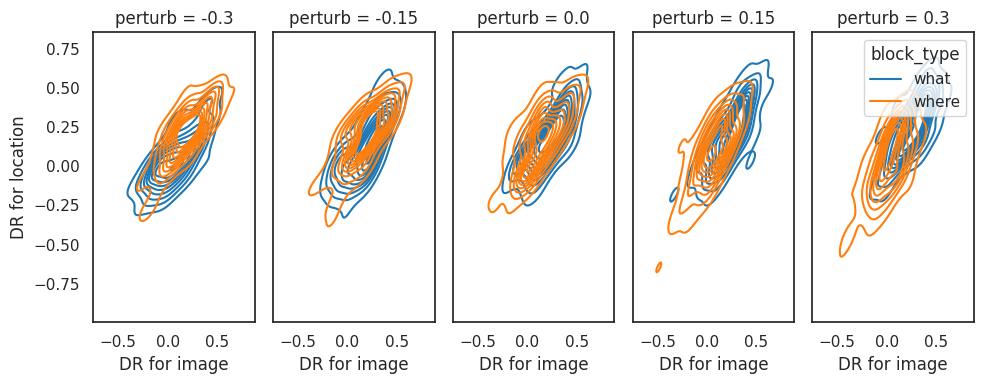

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(10,4))
p1, p2, p3, p4, p5 = nef_dr['perturb'].unique()[[0, 3, 6, 9, 12]]
sns.kdeplot(data=nef_dr.query("perturb==@p1"), x='DR_let', y='DR_loc', hue='block_type', palette=palette[:2], ax=axes[0])
sns.kdeplot(data=nef_dr.query("perturb==@p2"), x='DR_let', y='DR_loc', hue='block_type', palette=palette[:2], ax=axes[1])
sns.kdeplot(data=nef_dr.query("perturb==@p3"), x='DR_let', y='DR_loc', hue='block_type', palette=palette[:2], ax=axes[2])
sns.kdeplot(data=nef_dr.query("perturb==@p4"), x='DR_let', y='DR_loc', hue='block_type', palette=palette[:2], ax=axes[3])
sns.kdeplot(data=nef_dr.query("perturb==@p5"), x='DR_let', y='DR_loc', hue='block_type', palette=palette[:2], ax=axes[4])
axes[0].set(title=f'perturb = {np.around(p1,2)}', ylabel='DR for location', xlabel='DR for image')
axes[1].set(title=f'perturb = {np.around(p2,2)}', xlabel='DR for image')
axes[2].set(title=f'perturb = {np.around(p3,2)}', xlabel='DR for image')
axes[3].set(title=f'perturb = {np.around(p4,2)}', xlabel='DR for image')
axes[4].set(title=f'perturb = {np.around(p5,2)}', xlabel='DR for image')
axes[0].get_legend().remove()
axes[1].get_legend().remove()
axes[2].get_legend().remove()
axes[3].get_legend().remove()
plt.tight_layout()
fig.savefig("plots/nef_dr_heatmaps_vs_perturbation.pdf")

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(10,4))
sns.lineplot(data=nef_dr.query("perturb==-0.2 & "), x='DR_let', y='DR_loc', hue='block_type', palette=palette[:2], ax=axes[0])
# sns.lineplot(data=nef_dr.query("perturb==-0.1"), x='DR_let', y='DR_loc', hue='block_type', palette=palette[:2], ax=axes[1])
# sns.lineplot(data=nef_dr.query("perturb==0.0"), x='DR_let', y='DR_loc', hue='block_type', palette=palette[:2], ax=axes[2])
# sns.lineplot(data=nef_dr.query("perturb==0.1"), x='DR_let', y='DR_loc', hue='block_type', palette=palette[:2], ax=axes[3])
# sns.lineplot(data=nef_dr.query("perturb==0.2"), x='DR_let', y='DR_loc', hue='block_type', palette=palette[:2], ax=axes[4])
axes[0].set(title='perturb = -0.2')
axes[1].set(title='perturb = -0.1')
axes[2].set(title='perturb = 0.0')
axes[3].set(title='perturb = 0.1')
axes[4].set(title='perturb = 0.2')
axes[0].get_legend().remove()
axes[1].get_legend().remove()
axes[2].get_legend().remove()
axes[3].get_legend().remove()
plt.tight_layout()
plt.show()

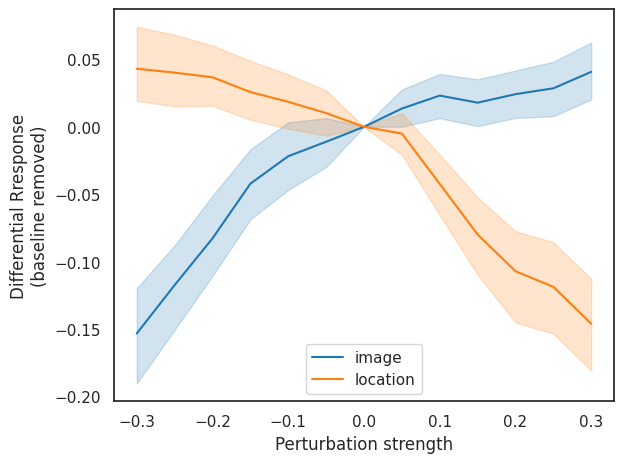

In [29]:
fig, ax = plt.subplots()
sns.lineplot(data=nef_dr0.query("block_type=='what'"), x='perturb', y='DR_let_diff', color=palette[0], ax=ax, label='image')
sns.lineplot(data=nef_dr0.query("block_type=='where'"), x='perturb', y='DR_loc_diff', color=palette[1], ax=ax, label='location')
ax.legend()
ax.set(ylabel='Differential Rresponse\n(baseline removed)', xlabel="Perturbation strength")
plt.tight_layout()
fig.savefig("plots/nef_differential_response_vs_perturbation.pdf")